# 0. 필요한 모듈 설치

In [1]:
# !pip install --upgrade pip
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install xlrd

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [3]:
# 한글폰트 설정
import matplotlib
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
font_location = 'NanumGothic.ttf'
fprop = fm.FontProperties(fname=font_location) 
# title/xlabelticks/ylabelticks/xlabel/ylabel: fontproperties=fprop
# legend: prop=fprop

# 마이너스 부호 설정
mpl.rcParams['axes.unicode_minus'] = False

# 1.데이터 전처리

## 1) 오프라인 구매이력 데이터

### ① 데이터 병합
- 병합 대상 데이터: 삼성카드, 신한카드
- 병합 방식
  + 업종: 신한카드 업종(30개) -> 삼성카드 업종(14개)로 분류 후 병합
  + 성별: 신한카드 성별(F,M) -> 삼성카드 성별(남,녀)로 변경 후 병합


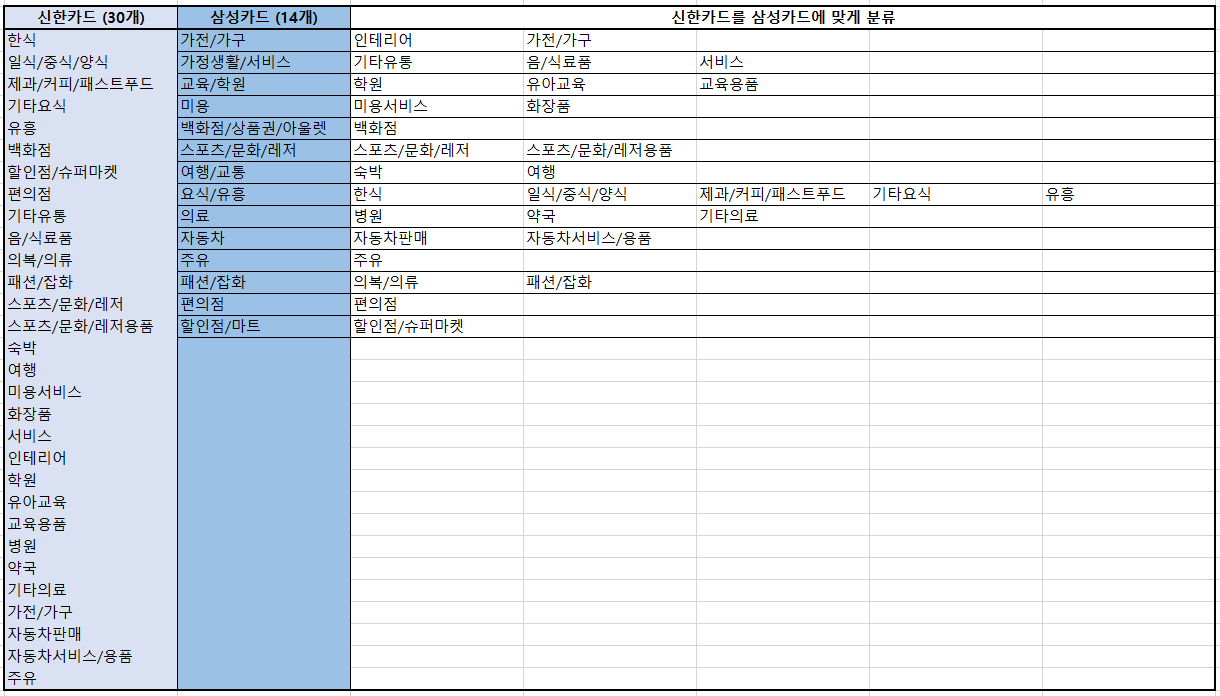

In [4]:
# 삼성카드
samsung = pd.read_csv('sample/Samsungcard.csv',encoding='CP949')
samsung.head()

,소비일자,소비업종,성별,연령대,소비건수
0,20190101,가전/가구,남성,20대,5529
1,20190101,가전/가구,남성,30대,17536
2,20190101,가전/가구,남성,40대,22838
3,20190101,가전/가구,남성,50대,15801
4,20190101,가전/가구,남성,60대,6772


In [5]:
# 신한카드
shinhan=pd.read_excel('sample/Shinhancard.xlsx')
del shinhan['Unnamed: 5']
del shinhan['Unnamed: 6']
del shinhan['Unnamed: 7']

# 삼성카드 컬럼명과 동일하게 변경
shinhan.columns=['소비일자','성별','연령대','소비업종','소비건수'] 

# 삼성카드 소비건수 단위와 동일하게 변경
shinhan['소비건수'] = shinhan['소비건수'] * 1000

# 삼성카드 성별명과 동일하게 변경
shinhan['성별'] = [ '여성' if x =='F' else '남성' for x in shinhan['성별'] ]
shinhan.head()

,소비일자,성별,연령대,소비업종,소비건수
0,20190101,여성,20대,M001_한식,298900.0
1,20190101,여성,20대,M002_일식/중식/양식,88300.0
2,20190101,여성,20대,M003_제과/커피/패스트푸드,290600.0
3,20190101,여성,20대,M004_기타요식,446300.0
4,20190101,여성,20대,M005_유흥,24200.0


In [6]:
# 신한카드: 삼성카드 소비업종과 동일하게 분류
for indx, category in enumerate(shinhan['소비업종']):
    if (category == 'M020_인테리어' or category == 'M027_가전/가구'):
        shinhan['소비업종'][indx] = '가전/가구'

    elif (category in ['M009_기타유통','M010_음/식료품','M019_서비스']):
        shinhan['소비업종'][indx] = '가정생활/서비스'
  
    elif (category in ['M021_학원','M022_유아교육','M023_교육용품']):
        shinhan['소비업종'][indx]='교육/학원'
  
    elif (category in ['M017_미용서비스','M018_화장품']):
        shinhan['소비업종'][indx]='미용'
  
    elif (category in ['M006_백화점']):
        shinhan['소비업종'][indx]='백화점/상품권/아울렛'

    elif (category in ['M013_스포츠/문화/레저','M014_스포츠/문화/레저용품']):
        shinhan['소비업종'][indx]='스포츠/문화/레저'
  
    elif (category in ['M015_숙박','M016_여행']):
        shinhan['소비업종'][indx] = '여행/교통'

    elif (category in ['M001_한식','M002_일식/중식/양식','M003_제과/커피/패스트푸드','M004_기타요식','M005_유흥']):
        shinhan['소비업종'][indx] = '요식/유흥'

    elif (category in ['M024_병원','M025_약국','M026_기타의료']):
        shinhan['소비업종'][indx] = '의료'

    elif (category in ['M028_자동차판매','M029_자동차서비스/용품']):
        shinhan['소비업종'][indx] = '자동차'

    elif (category in ['M030_주유']):
        shinhan['소비업종'][indx] = '주유'

    elif (category in ['M011_의복/의류','M012_패션/잡화']):
        shinhan['소비업종'][indx] = '패션/잡화'

    elif (category in ['M008_편의점']):
        shinhan['소비업종'][indx] = '편의점'

    elif (category in ['M007_할인점/슈퍼마켓']):
        shinhan['소비업종'][indx] = '할인점/슈퍼마켓'

In [7]:
# 오프라인 데이터 병합
offline = pd.concat([samsung, shinhan])
offline.head()

,소비일자,소비업종,성별,연령대,소비건수
0,20190101,가전/가구,남성,20대,5529.0
1,20190101,가전/가구,남성,30대,17536.0
2,20190101,가전/가구,남성,40대,22838.0
3,20190101,가전/가구,남성,50대,15801.0
4,20190101,가전/가구,남성,60대,6772.0


### ② 상반기 데이터 추출
- 전년도와 비교하기 위해 상반기 데이터만 추출

In [8]:
# 상반기 데이터만 추출
offline['소비일자'] = offline['소비일자'].astype('str')
df = pd.DataFrame()
for year in ('2019', '2020'):
    for month in ('01','02','03','04','05','06'):
        date = year + month
        new_df = offline[offline['소비일자'].str.contains(date)]
        df = pd.concat([df,new_df])
offline = df
offline.head()

,소비일자,소비업종,성별,연령대,소비건수
0,20190101,가전/가구,남성,20대,5529.0
1,20190101,가전/가구,남성,30대,17536.0
2,20190101,가전/가구,남성,40대,22838.0
3,20190101,가전/가구,남성,50대,15801.0
4,20190101,가전/가구,남성,60대,6772.0


## 2) 온라인 구매 이력 데이터

### ① 데이터 병합
- 병합 대상 데이터: Mcorporation 64종 업종별 구매이력 데이터
- 병합 방식: 컬럼명 기준으로 병합

In [9]:
# 소비업종 리스트
categories = pd.read_excel('sample/Mcorporation/상품 카테고리 데이터_KDX 시각화 경진대회 Only/KDX_CONTEST_파일정의서.xlsx')['xlsx 파일 이름'].values
categories = list(categories)

# 파일정의서에 정의된 파일명과 실제 파일명 일치시킴
categories = ['도서음반DVD' if x =='도서음반' else x for x in categories]
categories[:5]

['PC사무기기', 'TV홈시어터', '가공식품', '가방지갑잡화', '건강식품']

In [10]:
# 온라인 데이터 병합
mcorp = pd.DataFrame()
for i, category in enumerate(categories):
    path = 'sample/Mcorporation/상품 카테고리 데이터_KDX 시각화 경진대회 Only/{}.xlsx'.format(category)
    df = pd.read_excel(path)
    df['카테고리명'] = category
    mcorp = pd.concat((mcorp, df), axis=0)
    print(category, i)
mcorp.head()

PC사무기기 0
TV홈시어터 1
가공식품 2
가방지갑잡화 3
건강식품 4
골프용품 5
공구류 6
구기 7
기타 스포츠 8
낚시 9
남성의류 10
계절가전 11
노트북 12
농축수산물 13
도서음반DVD 14
등산용품 15
메이크업 16
문구사무용품 17
미용가전 18
반려동물 19
생활용품 20
생활가구 21
생활가전 22
서비스티켓 23
성인용품 24
세탁청소세면 25
수납가구 26
수납가구 27
수영 28
스키보드 29
스킨케어 30
스포츠의류 31
신발 32
악세서리시계주얼리 33
안전용품 34
언더웨어 35
업소위생용품 36
여성의류 37
국내외여행 38
완구키덜트게임 39
욕실용품 40
욕실가전 41
유아용품 42
유아패션 43
음료 44
음향가전 45
인테리어용품 46
자동차용품 47
자전거사이클보드인라인 48
주방가전 49
주방수납잡화 50
주방식기용기 51
주방조리기구 52
출산임부용품 53
취미악기 54
침실가구 55
침실인테리어 56
카메라캠코더 57
캠핑용품 58
테마의류 59
헤어바디용품 60
헬스기구용품 61
건강관련용품 62
휴대폰악세서리 63


,구매날짜,카테고리명,고객성별,고객나이,OS유형,구매금액,구매수
0,20190101,PC사무기기,F,10,IOS,352443,13
1,20190101,PC사무기기,F,10,WINDOWS,84000,1
2,20190101,PC사무기기,F,10,안드로이드,80870,8
3,20190101,PC사무기기,F,10,없음,3700,1
4,20190101,PC사무기기,F,20,IOS,27714776,381


### ② 데이터 정제
- 연령대 처리
  + 0보다 작은 값과 0인 값에 해당하는 행 삭제(데이터 담당자 확인 결과 의미 없는 값으로 판명)
  + 80, 90, 100, 110, 120 인 값은 모두 70대로 변경
  + 연령대 70은 70대 이상으로 간주
- 컬럼명 처리
  + 편의를 위해 컬럼명 오프라인 데이터 컬럼과 동일하게 변경

|_변경전_||구매날짜|카테고리명|고객성별|고객나이|OS유형|구매금액|구매수|
|---||---|---|---|---|---|---|---|
|_변경후_||**소비일자**|**소비업종**|**성별**|**연령대**|**OS유형**|**소비금액**|**소비건수**|

In [11]:
# 연령대 처리
temp = mcorp[~mcorp['고객나이'].isin([0,-10,-20,-30,-40,-50,-60,-70,-80])]
temp['고객나이'] = [70 if x>=70 else x for x in temp['고객나이']]
mcorp = temp

# 컬럼명 처리
mcorp.columns = ['소비일자','소비업종','성별','연령대','OS유형','소비금액','소비건수']

### ③ 상반기 데이터 추출
- 전년도와 비교하기 위해 상반기 데이터만 추출

In [12]:
online = mcorp.copy()

# 상반기 데이터만 추출
online['소비일자'] = online['소비일자'].astype('str')
df = pd.DataFrame()
for year in ('2019', '2020'):
    for month in ('01','02','03','04','05','06'):
        date = year + month
        new_df = online[online['소비일자'].str.contains(date)]
        df = pd.concat([df,new_df])
online = df 
online.head() 

,소비일자,소비업종,성별,연령대,OS유형,소비금액,소비건수
0,20190101,PC사무기기,F,10,IOS,352443,13
1,20190101,PC사무기기,F,10,WINDOWS,84000,1
2,20190101,PC사무기기,F,10,안드로이드,80870,8
3,20190101,PC사무기기,F,10,없음,3700,1
4,20190101,PC사무기기,F,20,IOS,27714776,381


## 3) 코로나 확진자 데이터
- [KDX 코로나바이러스감염증-19(COVID-19) 현황 데이터](https://kdx.kr/data/view?product_id=25918) 사용
- Covid19InfState 파일 사용

### ① 데이터 정제
- 날짜 중복값 처리: 일별 최종 보고 확진자수로 처리

In [13]:
corona = pd.read_csv('Covid19InfState.csv')

# 날짜 중복값 처리
corona = corona.drop_duplicates(['stateDt'],keep='last')
corona['stateDt'] = corona['stateDt'].astype('str')
corona = corona.reset_index(drop=True)

# 결측치 처리 (네이버 일별 확진자 참고)
corona['decideCnt'][0] = 0
corona['decideCnt'][3] = 15
corona.head()

,seq,stateDt,stateTime,decideCnt,clearCnt,examCnt,deathCnt,careCnt,resutlNegCnt,accExamCnt,accExamCompCnt,accDefRate,createDt,updateDt
0,1,20200201,18:00,0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-31 17:47:33.33,2020-02-03 12:21:56.56
1,2,20200202,09:00,2,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,2020-02-03 12:22:49.49,NaN
2,3,20200203,09:00,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-03 14:41:17.17,2020-02-04 14:19:46.46
3,4,20200204,00:00,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-03 21:26:59.59,NaN
4,6,20200205,19:00,19,1.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-05 20:05:40.40,2020-02-06 10:05:36.36


### ② 일별 확진자 수 추출
- 해당 날짜와 해당 다음 날짜의 누적확진자수 차이 값 추출

In [14]:
corona['decideCnt_day'] = corona['decideCnt']
for i in range(len(corona)):
    try:
        corona['decideCnt_day'][i] =  corona['decideCnt'][i+1] - corona['decideCnt'][i]
    except:
        corona['decideCnt_day'][i] = 61   # 9/25일 일별확진자 수는 네이버에서 가져옴

corona = corona[['stateDt','decideCnt_day']]
corona.columns=['날짜','일일확진자수']
corona.head()

,날짜,일일확진자수
0,20200201,2
1,20200202,13
2,20200203,0
3,20200204,4
4,20200205,4


In [15]:
# 코로나 확진자 수 출력
def corona_cnt(sdate=20200201, edate=20201231):
    corona_s = corona[corona['날짜'].astype('int') >= sdate]
    corona_e = corona_s[corona_s['날짜'].astype('int') <= edate]
    corona_e = corona_e[['날짜','일일확진자수']]
    corona_e.reset_index(drop=True, inplace=True)  
    return corona_e

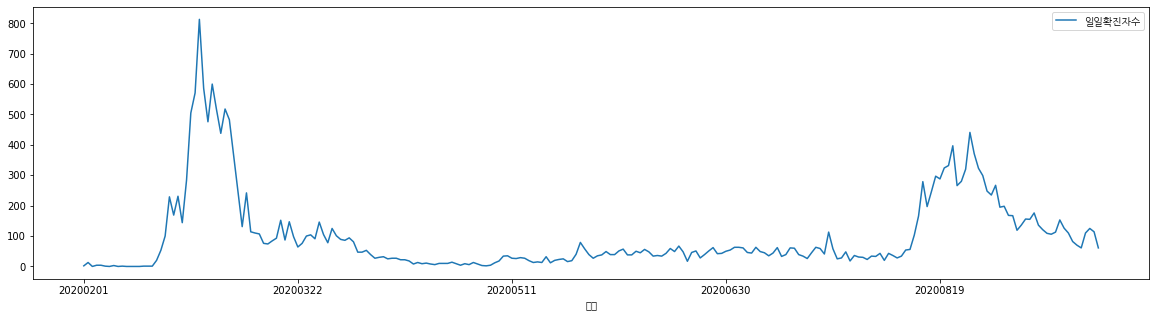

In [16]:
plt.rcParams["figure.figsize"] = (20,5)
corona_cnt(20200201, 20201231).plot(x='날짜',y='일일확진자수')
plt.legend(prop=fprop)
plt.show()

# 2. [분석1] 코로나와 오프라인 구매

## 1) 오프라인 소비와 코로나 확진자 추이

In [17]:
offline['소비일자'] = offline['소비일자'].astype('str')
offline_df = offline[(offline['소비일자'].str.contains('202002')) | (offline['소비일자'].str.contains('202003')) | (offline['소비일자'].str.contains('201902')) | (offline['소비일자'].str.contains('201903'))]
offline_df = pd.DataFrame(offline_df.groupby(['소비일자'])['소비건수'].sum())
offline_df.reset_index(inplace=True, drop=False)
offline_df.columns = ['날짜','소비건수']

corona_df = corona_cnt(20190101,20200331)
offline_corona_df = pd.merge(offline_df,corona_df, how='outer', on='날짜')

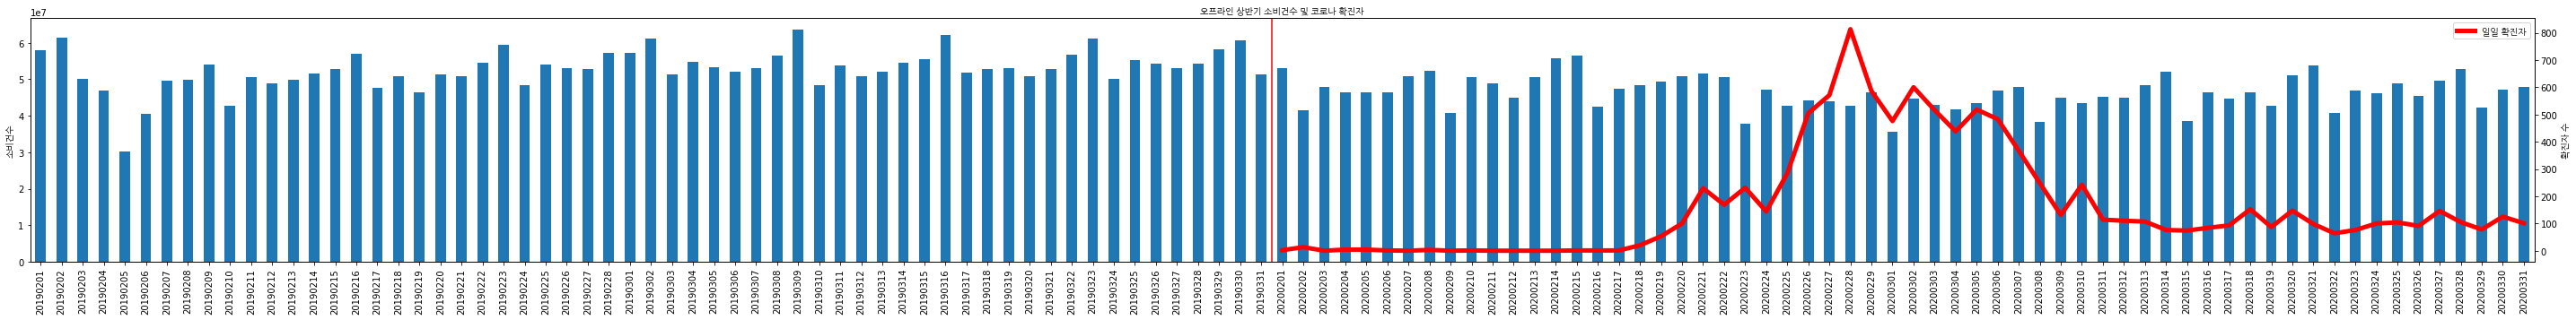

In [18]:
xtic = np.arange(0, len(offline_corona_df), step=1)
xdays = [offline_corona_df['날짜'][i] for i in xtic]

fig = plt.figure(figsize=(50, 5))
ax1 = offline_corona_df['소비건수'].plot(kind='bar',label="카드")
ax1.set_ylabel("소비건수",fontdict={'fontsize':20},fontproperties=fprop)
ax1.set_xticks(xtic)
ax1.set_xticklabels(xdays)

ax2 = offline_corona_df['일일확진자수'].plot(secondary_y=True, label="일일 확진자",color='red',rot=90,linewidth=5.0)
ax2.set_ylabel("확진자 수",fontdict={'fontsize':20},fontproperties=fprop)
ax2.axvline(x=58.5, color='red')

plt.title('오프라인 상반기 소비건수 및 코로나 확진자',fontdict={'fontsize':25},fontproperties=fprop)
plt.legend(prop=fprop)
plt.show()

## 2) 전체 오프라인 소비건수 현황

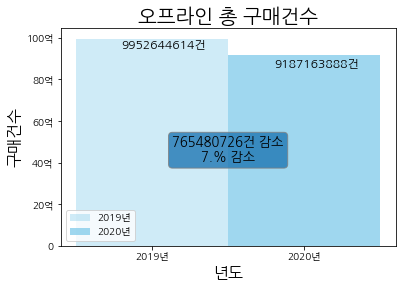

In [19]:
a = offline[offline['소비일자'].str.contains('2019')]['소비건수'].sum()
b = offline[offline['소비일자'].str.contains('2020')]['소비건수'].sum()
c = b-a
d = c/a * 100
e = str(abs(c))[:-2] + '건 감소' + '\n' + str(abs(d))[:2] + '% 감소'

plt.rcParams['figure.figsize'] = [6, 4]
labels = ['2019년','2020년']
x = [0, 0.5]
width = 0.5

fig, ax = plt.subplots()
rects1 = ax.bar(0, height=a, width=width, label='2019년', color='skyblue', alpha=0.4)
rects2 = ax.bar(0.5, height=b, width=width, label='2020년', color='skyblue', alpha=0.8)

ax.set_ylabel('구매건수',fontsize=16,fontproperties=fprop)
ax.set_xlabel('년도',fontsize=16,fontproperties=fprop)
ax.set_title('오프라인 총 구매건수',fontsize=20,fontproperties=fprop)

ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14,fontproperties=fprop)
for label in ax.get_xticklabels():
    label.set_fontproperties(fprop)
ax.set_yticks(np.arange(0, 10000000001,2000000000))
ax.set_yticklabels(['0', '20억', '40억', '60억', '80억','100억'],fontproperties=fprop)
for label in ax.get_yticklabels():
    label.set_fontproperties(fprop)
ax.annotate(str(a)[:-2]+'건',xy=(-0.1,a-a*0.05),fontsize=12,fontproperties=fprop)
ax.annotate(str(b)[:-2]+'건',xy=(0.4,b-b*0.07),fontsize=12,fontproperties=fprop)
ax.annotate(e, xy=(0.25,b/2),size=13, ha='center', va="center", bbox=dict(boxstyle="round", alpha=0.8, ec="gray"),fontproperties=fprop)

ax.legend(loc='lower left',prop=fprop)
plt.show()

## 3) 히트맵 시각화 및 업종 클러스터링

In [20]:
# 함수: 기간별, 업종별 소비건수 합계 추출
def categorical_cnt(onoff=0, category='category',sdate=2019101, edate=20201231):
    if onoff == 0 :
        online['소비일자'] = online['소비일자'].astype('int')
        df = pd.DataFrame(online[online['소비업종']==category].groupby(['소비일자'])['소비건수'].sum())
        df_s = df[df.index >= sdate]
        df_e = df_s[df_s.index <= edate]
        df_e.reset_index(drop=False,inplace=True)
        df_e.columns=['날짜','소비건수']
        df_e['날짜'] = df_e['날짜'].astype('str')
        return df_e
    else:
        offline['소비일자'] = offline['소비일자'].astype('int')
        df = pd.DataFrame(offline[offline['소비업종']==category].groupby(['소비일자'])['소비건수'].sum())
        df_s = df[df.index >= sdate]
        df_e = df_s[df_s.index <= edate]
        df_e.reset_index(drop=False,inplace=True)
        df_e.columns=['날짜','소비건수']
        df_e['날짜'] = df_e['날짜'].astype('str')
    return df_e

In [21]:
# 함수: 기간별, 업종별 소비건수 및 코로나 일일확진자수 데이터프레임 생성
def categorical_corona_cnt(onoff=0, category='category',sdate=20200101, edate=20201231):
    df = pd.merge(categorical_cnt(onoff=onoff,category=category,sdate=sdate, edate=edate), corona_cnt(sdate=sdate, edate=edate))
    df.columns=['날짜',category,'일일확진자수']
    return df

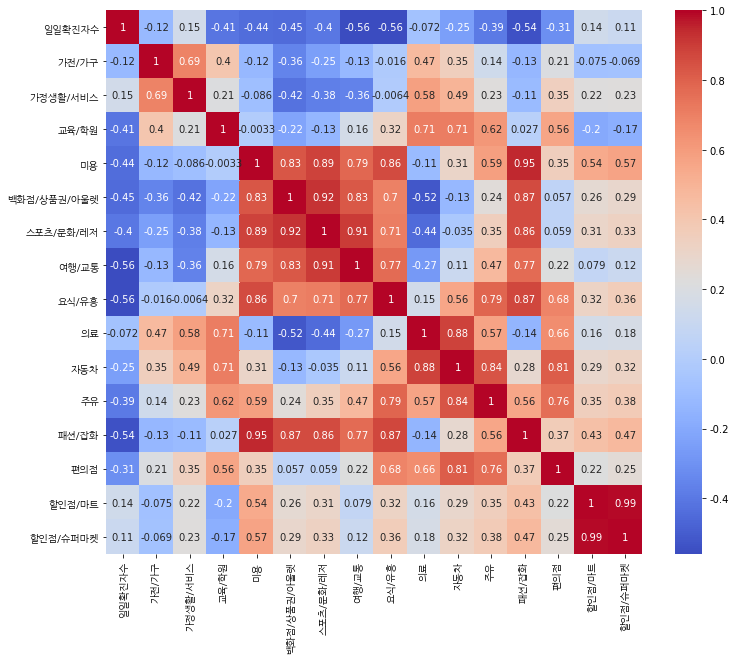

In [22]:
categories = pd.unique(offline['소비업종'].values)
corr = pd.DataFrame()
for category in categories:
    corr['일일확진자수'] = corona_cnt(sdate=20200201, edate=20200331)['일일확진자수']
    category_value = categorical_corona_cnt(1,category,sdate=20200201, edate=20200331)[category]
    corr[category] = category_value
corr.set_index(categorical_corona_cnt(1,category,sdate=20200201, edate=20200331)['날짜'],inplace=True)

corr_heatmap = corr.corr()
plt.rcParams['figure.figsize']=[12,10]
g = sns.heatmap(corr_heatmap, annot=True,cmap='coolwarm')

# 히트맵 한글 폰트
g.set_xticklabels(g.xaxis.get_majorticklabels(),fontproperties=fprop)
for label in g.xaxis.get_majorticklabels():
    label.set_fontproperties(fprop)
g.set_yticklabels(g.yaxis.get_majorticklabels(),fontproperties=fprop)
for label in g.yaxis.get_majorticklabels():
    label.set_fontproperties(fprop)

히트맵을 활용하여
- 코로나와 상관관계 지닌 업종 선별
- 해당 업종들 간 상관관계가 높은 것 끼리 클러스터링 진행
  - 여가: 스포츠/문화/레저, 여행/교통
  - 뷰티: 미용, 백화점/상품권/아울렛, 패션/잡화
  - 외식: 요식/유흥
  - 교육: 교육/학원

### ① 여가 소비변화량 분석 및 시각화

In [23]:
# 함수: 전년대비 소비변화량 시각화
def barchart(onoff=0, category = 'category'):
    df = categorical_cnt(onoff, category)
    df_2019 = df[df['날짜'].str.contains('2019')]
    df_2020 = df[df['날짜'].str.contains('2020')]

    a = df_2019['소비건수'].sum()
    b = df_2020['소비건수'].sum()
    c = b-a
    d = round(c/a * 100)

    if onoff == 0 :
        e = str(abs(c)) + '건 증가' + '\n' + str(abs(d)) + '% 증가'
        plt.rcParams['figure.figsize'] = [6, 4]
        labels = ['2019년','2020년']
        width = 0.5

        fig, ax = plt.subplots()
        rects1 = ax.bar(0, height=a, width=width, label='2019년', color='yellowgreen', alpha=0.5)
        rects2 = ax.bar(0.5, height=b, width=width, label='2020년', color='yellowgreen', alpha=0.9)

        ax.set_ylabel('구매건수',fontsize=16,fontproperties=fprop)
        ax.set_xlabel('년도',fontsize=16,fontproperties=fprop)
        ax.set_title( category +'구매건수',fontsize=20,fontproperties=fprop)
        ax.annotate(str(a)+'건',xy=(-0.1,a-a*0.05),fontsize=12,fontproperties=fprop)
        ax.annotate(str(b)+'건',xy=(0.4,b-b*0.07),fontsize=12,fontproperties=fprop)
        ax.annotate(e, xy=(0.25,b/2),size=13, ha='center', va="center", bbox=dict(boxstyle="round", alpha=0.8, ec="gray"),fontproperties=fprop)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize=14)
        for label in ax.get_xticklabels() :
            label.set_fontproperties(fprop)
        ax.legend(loc='lower left',prop=fprop)
        plt.show()
    else:
        e = str(abs(c))[:-2] + '건 감소' + '\n' + str(abs(d)) + '% 감소'
    
        plt.rcParams['figure.figsize'] = [6, 4]
        labels = ['2019년','2020년']
        width = 0.5

        fig, ax = plt.subplots()
        rects1 = ax.bar(0, height=a, width=width, label='2019년', color='skyblue', alpha=0.4)
        rects2 = ax.bar(0.5, height=b, width=width, label='2020년', color='skyblue', alpha=0.8)

        ax.set_ylabel('구매건수',fontsize=16,fontproperties=fprop)
        ax.set_xlabel('년도',fontsize=16,fontproperties=fprop)
        ax.set_title( category +'구매건수',fontsize=20,fontproperties=fprop)
        ax.annotate(str(a)[:-2]+'건',xy=(-0.1,a-a*0.05),fontsize=12,fontproperties=fprop)
        ax.annotate(str(b)[:-2]+'건',xy=(0.4,b-b*0.07),fontsize=12,fontproperties=fprop)
        ax.annotate(e, xy=(0.25,b/2),size=13, ha='center', va="center", bbox=dict(boxstyle="round", alpha=0.8, ec="gray"),fontproperties=fprop)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize=14)
        for label in ax.get_xticklabels() :
            label.set_fontproperties(fprop)
        ax.legend(loc='lower left',prop=fprop)
        plt.show()

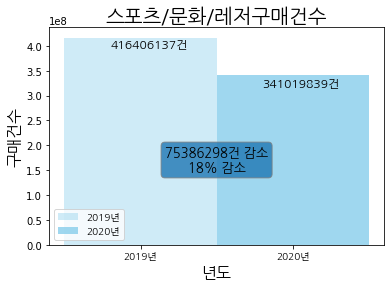

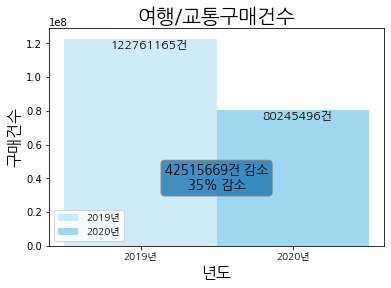

In [24]:
barchart(1,'스포츠/문화/레저')
barchart(1,'여행/교통')

### ② 뷰티 소비변화량 분석 및 시각화

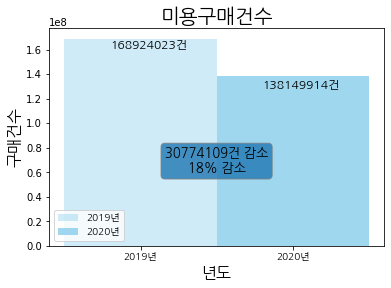

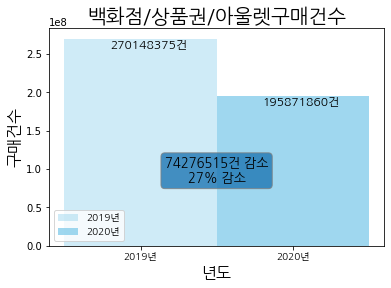

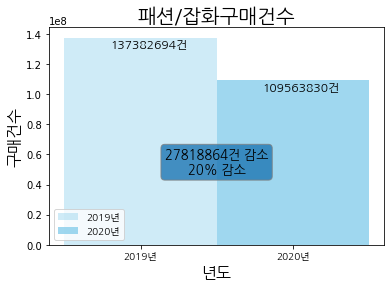

In [25]:
barchart(1,'미용')
barchart(1,'백화점/상품권/아울렛')
barchart(1,'패션/잡화')

### ③ 외식 소비변화량 분석 및 시각화

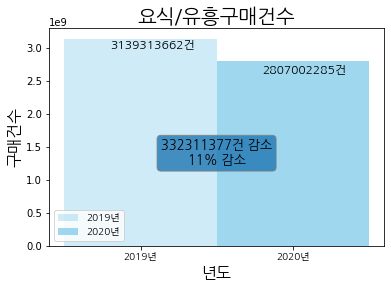

In [26]:
barchart(1,'요식/유흥')

### ④ 교육 소비변화량 분석 및 시각화

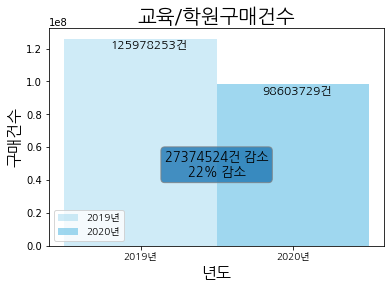

In [27]:
barchart(1,'교육/학원')

# 3. [분석2] 코로나와 온라인 구매

## 1) 온라인 소비와 코로나 확진자 추이

In [28]:
online['소비일자'] = online['소비일자'].astype('str')
online_df = online[(online['소비일자'].str.contains('202002')) | (online['소비일자'].str.contains('202003')) | (online['소비일자'].str.contains('201902')) | (online['소비일자'].str.contains('201903'))]
online_df = pd.DataFrame(online_df.groupby(['소비일자'])['소비건수'].sum())
online_df.reset_index(inplace=True, drop=False)
online_df.columns = ['날짜','소비건수']

corona_df = corona_cnt(20190101,20200331)
online_corona_df = pd.merge(online_df,corona_df, how='outer', on='날짜')

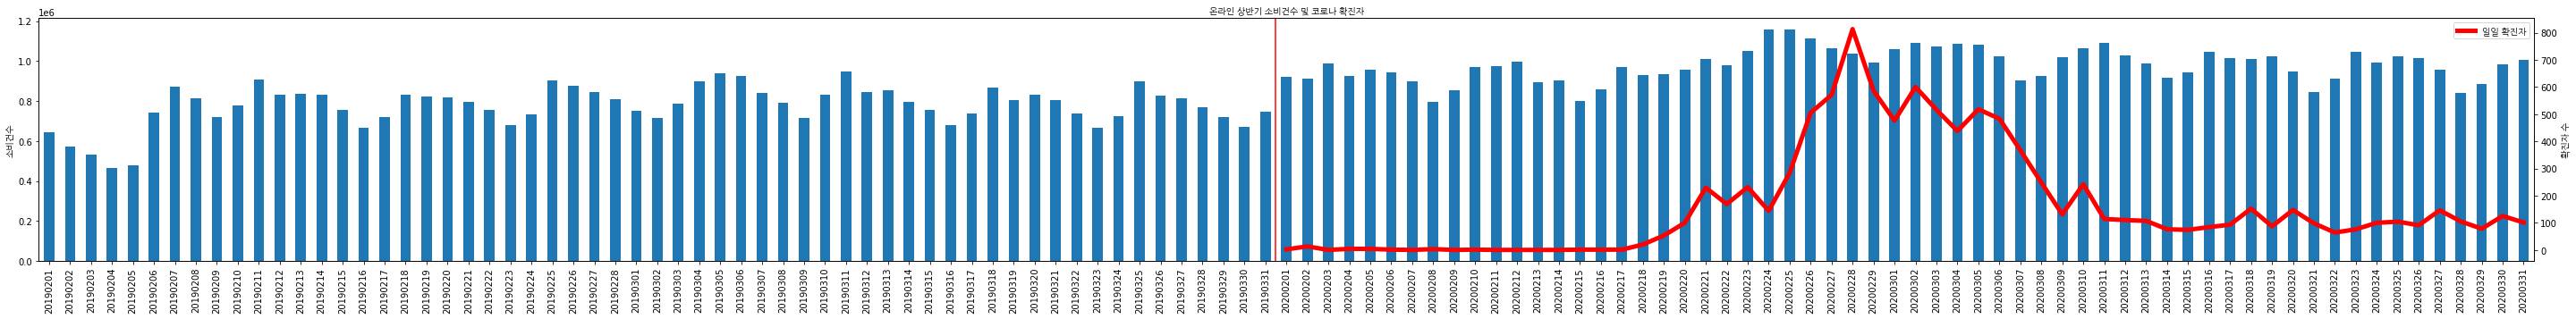

In [29]:
xtic = np.arange(0, len(online_corona_df), step=1)
xdays = [online_corona_df['날짜'][i] for i in xtic]

fig = plt.figure(figsize=(50, 5))
ax1 = online_corona_df['소비건수'].plot(kind='bar',label="카드")
ax1.set_ylabel("소비건수",fontdict={'fontsize':20},fontproperties=fprop)
ax1.set_xticks(xtic)
ax1.set_xticklabels(xdays)

ax2 = online_corona_df['일일확진자수'].plot(secondary_y=True, label="일일 확진자",color='red',rot=90,linewidth=5.0)
ax2.set_ylabel("확진자 수",fontdict={'fontsize':20},fontproperties=fprop)
ax2.axvline(x=58.5, color='red')


plt.title('온라인 상반기 소비건수 및 코로나 확진자',fontdict={'fontsize':25},fontproperties=fprop)
plt.legend(prop=fprop)
plt.show()

## 2) 전체 온라인 소비건수 현황

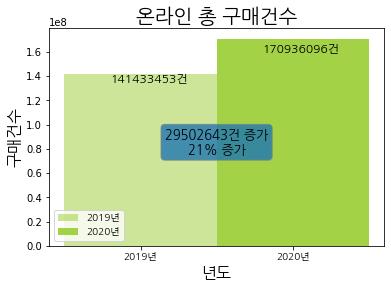

In [30]:
online['소비일자'] = online['소비일자'].astype('str')
a = online[online['소비일자'].str.contains('2019')]['소비건수'].sum()
b = online[online['소비일자'].str.contains('2020')]['소비건수'].sum()
c = b-a
d = c/a * 100
e = str(abs(c)) + '건 증가' + '\n' + str(round(abs(d))) + '% 증가'

plt.rcParams['figure.figsize'] = [6, 4]
labels = ['2019년','2020년']
x = [0, 0.5]
width = 0.5

fig, ax = plt.subplots()
rects1 = ax.bar(0, height=a, width=width, label='2019년', color='yellowgreen', alpha=0.5)
rects2 = ax.bar(0.5, height=b, width=width, label='2020년', color='yellowgreen', alpha=0.9)

ax.set_ylabel('구매건수',fontsize=16,fontproperties=fprop)
ax.set_xlabel('년도',fontsize=16,fontproperties=fprop)
ax.set_title('온라인 총 구매건수',fontsize=20,fontproperties=fprop)

ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14)
for label in ax.get_xticklabels() :
    label.set_fontproperties(fprop)
ax.annotate(str(a)+'건',xy=(-0.1,a-a*0.05),fontsize=12,fontproperties=fprop)
ax.annotate(str(b)+'건',xy=(0.4,b-b*0.07),fontsize=12,fontproperties=fprop)
ax.annotate(e, xy=(0.25,b/2),size=13, ha='center', va="center", bbox=dict(boxstyle="round", alpha=0.8, ec="gray"),fontproperties=fprop)

ax.legend(loc='lower left',prop=fprop)
plt.show()

## 3) 히트맵 시각화 및 업종 클러스터링

In [31]:
from scipy import stats

In [32]:
def corona_categorical_corr(onoff=0, category='category',sdate=20190101,edate=20201231):
    df = categorical_cnt(onoff=onoff, category=category,sdate=sdate, edate=edate)
    corona_df = corona_cnt(sdate=sdate,edate=edate)
    card_corona_df = pd.merge(df,corona_df, how='outer', on='날짜')
    corr_p=stats.pearsonr(card_corona_df['소비건수'],card_corona_df['일일확진자수'])
    return corr_p

In [33]:
pcorr_list = []
categories=list(online['소비업종'].unique())
for category in categories:
    corr_p = corona_categorical_corr(0,category,20200201,20200331)
    if abs(corr_p[0])>0.4:
        pcorr_list.append(category)
pcorr_list

['가공식품',
 '건강식품',
 '계절가전',
 '농축수산물',
 '생활용품',
 '세탁청소세면',
 '스킨케어',
 '안전용품',
 '업소위생용품',
 '국내외여행',
 '완구키덜트게임',
 '주방수납잡화',
 '헤어바디용품',
 '헬스기구용품',
 '건강관련용품']

- 64종을 모두 히트맵으로 시각화하기 어려우므로, 상관관계 분석 후 0.4 이상인 값만 추출

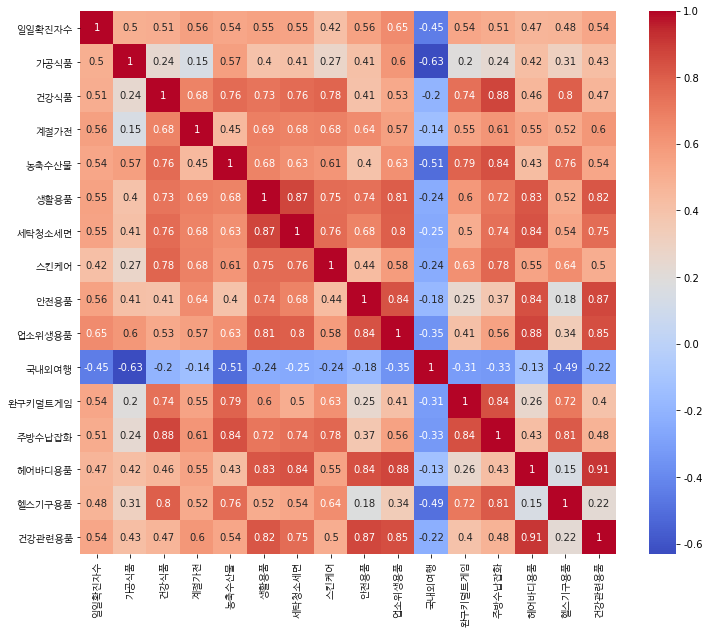

In [34]:
categories = pcorr_list
corr = pd.DataFrame()
for category in categories:
    corr['일일확진자수'] = corona_cnt(sdate=20200201, edate=20200331)['일일확진자수']
    category_value = categorical_corona_cnt(0,category,sdate=20200201, edate=20200331)[category]
    corr[category] = category_value
corr.set_index(categorical_corona_cnt(0,category,sdate=20200201, edate=20200331)['날짜'],inplace=True)

corr_heatmap = corr.corr()
plt.rcParams['figure.figsize']=[12,10]
g = sns.heatmap(corr_heatmap, annot=True, cmap='coolwarm')

# 히트맵 한글 폰트
g.set_xticklabels(g.xaxis.get_majorticklabels(),fontproperties=fprop)
for label in g.xaxis.get_majorticklabels():
    label.set_fontproperties(fprop)
g.set_yticklabels(g.yaxis.get_majorticklabels(),fontproperties=fprop)
for label in g.yaxis.get_majorticklabels():
    label.set_fontproperties(fprop)

히트맵을 활용하여
- 코로나와 상관관계 지닌 업종 선별
- 해당 업종들 간 상관관계가 높은 것 끼리 클러스터링 진행
  - 코로나 예방품: 건강관련용품, 안전용품, 업소위생용품
  - 식사: 가공식품, 농축수산물, 건강식품
  - 생활: 헤어바디용품, 생활용품, 세탁청소세면
  - 취미: 완구키덜트게임, 헬스기구용품, 주방수납잡화

### ① 코로나 예방품 소비변화량 분석 및 시각화
- 건강관련용품, 안전용품, 업소위생용품

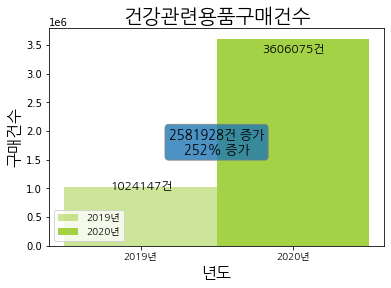

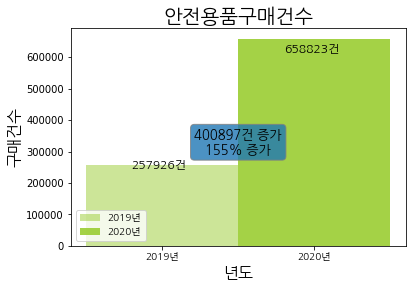

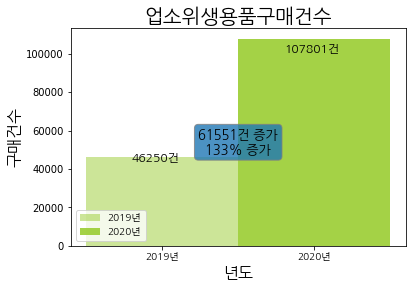

In [35]:
barchart(0,'건강관련용품')
barchart(0,'안전용품')
barchart(0,'업소위생용품')

### ② 식사 소비변화량 분석 및 시각화
- 가공식품, 농축수산물, 건강식품

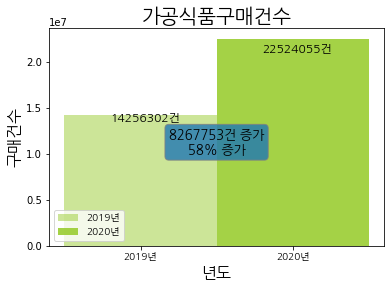

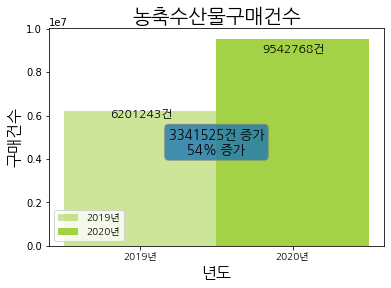

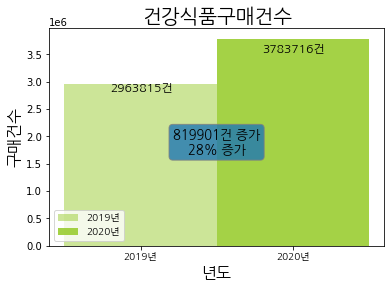

In [36]:
barchart(0,'가공식품')
barchart(0,'농축수산물')
barchart(0,'건강식품')

### ③ 생활 소비변화량 분석 및 시각화
- 헤어바디용품, 생활용품, 세탁청소세면

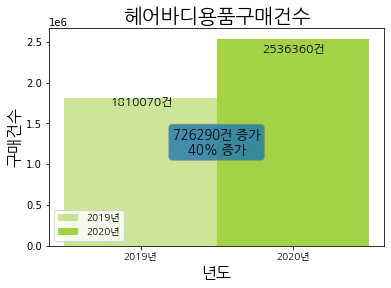

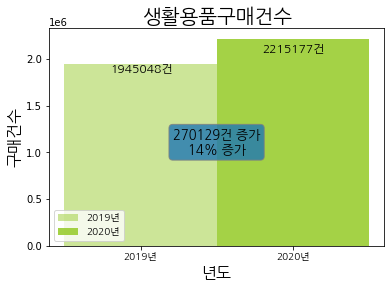

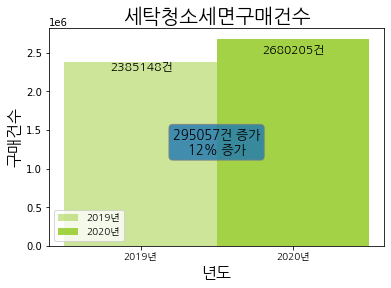

In [37]:
barchart(0,'헤어바디용품')
barchart(0,'생활용품')
barchart(0,'세탁청소세면')

### ④ 취미 소비변화량 분석 및 시각화
- 완구키덜트게임, 헬스기구용품, 주방수납잡화

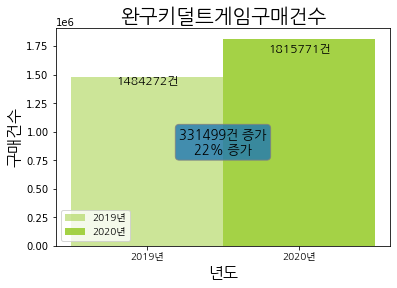

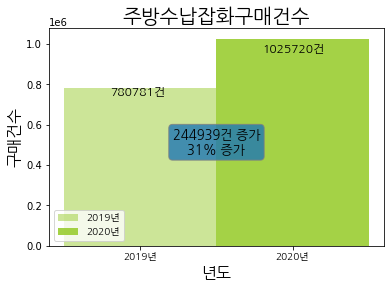

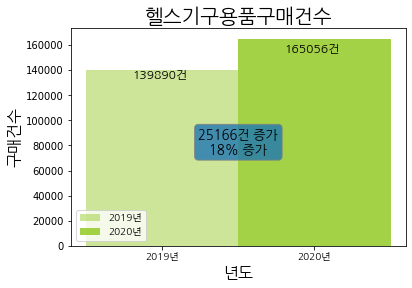

In [38]:
barchart(0,'완구키덜트게임')
barchart(0,'주방수납잡화')
barchart(0,'헬스기구용품')

# 3-1.[번외] OS 데이터 기반 소비 매체 분석

## 1) OS 전체 분석 및 시각화

In [39]:
online_OS = online.replace({'IOS':'Mobile','안드로이드':"Mobile",'WINDOWS':'PC'})
online_OS = online_OS[online_OS.OS유형!='없음']
online_OS = online_OS[online_OS.연령대!=10]
online_OS.reset_index(inplace=True,drop=True)
online_OS.head()

,소비일자,소비업종,성별,연령대,OS유형,소비금액,소비건수
0,20190101,PC사무기기,F,20,Mobile,27714776,381
1,20190101,PC사무기기,F,20,PC,11414514,60
2,20190101,PC사무기기,F,20,Mobile,21223319,252
3,20190101,PC사무기기,F,30,Mobile,44723699,240
4,20190101,PC사무기기,F,30,PC,19714978,75


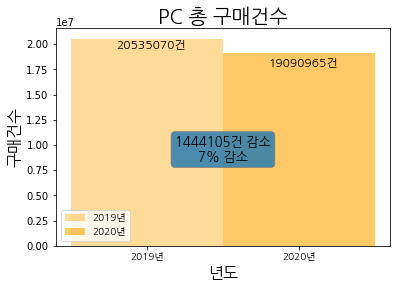

In [40]:
online_OS['소비일자'] = online_OS['소비일자'].astype('str')
a = online_OS[ (online_OS['소비일자'].str.contains('2019')) & (online_OS['OS유형']=='PC')]['소비건수'].sum()
b = online_OS[ (online_OS['소비일자'].str.contains('2020')) & (online_OS['OS유형']=='PC')]['소비건수'].sum()
c = b-a
d = c/a * 100
e = str(abs(c)) + '건 감소' + '\n' + str(round(abs(d))) + '% 감소'

plt.rcParams['figure.figsize'] = [6, 4]
labels = ['2019년','2020년']
x = [0, 0.5]
width = 0.5

fig, ax = plt.subplots()
rects1 = ax.bar(0, height=a, width=width, label='2019년', color='orange', alpha=0.4)
rects2 = ax.bar(0.5, height=b, width=width, label='2020년', color='orange', alpha=0.6)

ax.set_ylabel('구매건수',fontsize=16,fontproperties=fprop)
ax.set_xlabel('년도',fontsize=16,fontproperties=fprop)
ax.set_title('PC 총 구매건수',fontsize=20,fontproperties=fprop)

ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14)
for label in ax.get_xticklabels() :
    label.set_fontproperties(fprop)
ax.annotate(str(a)+'건',xy=(-0.1,a-a*0.05),fontsize=12,fontproperties=fprop)
ax.annotate(str(b)+'건',xy=(0.4,b-b*0.07),fontsize=12,fontproperties=fprop)
ax.annotate(e, xy=(0.25,b/2),size=13, ha='center', va="center", bbox=dict(boxstyle="round", alpha=0.8, ec="gray"),fontproperties=fprop)

ax.legend(loc='lower left',prop=fprop)
plt.show()

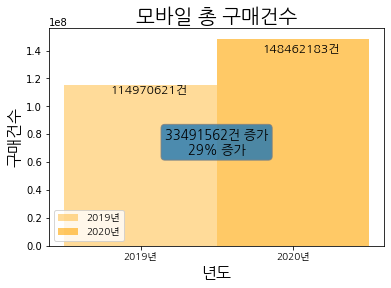

In [41]:
online_OS['소비일자'] = online_OS['소비일자'].astype('str')
a = online_OS[ (online_OS['소비일자'].str.contains('2019')) & (online_OS['OS유형']=='Mobile')]['소비건수'].sum()
b = online_OS[ (online_OS['소비일자'].str.contains('2020')) & (online_OS['OS유형']=='Mobile')]['소비건수'].sum()
c = b-a
d = c/a * 100
e = str(abs(c)) + '건 증가' + '\n' + str(round(abs(d))) + '% 증가'

plt.rcParams['figure.figsize'] = [6, 4]
labels = ['2019년','2020년']
x = [0, 0.5]
width = 0.5

fig, ax = plt.subplots()
rects1 = ax.bar(0, height=a, width=width, label='2019년', color='orange', alpha=0.4)
rects2 = ax.bar(0.5, height=b, width=width, label='2020년', color='orange', alpha=0.6)

ax.set_ylabel('구매건수',fontsize=16,fontproperties=fprop)
ax.set_xlabel('년도',fontsize=16,fontproperties=fprop)
ax.set_title('모바일 총 구매건수',fontsize=20,fontproperties=fprop)

ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14)
for label in ax.get_xticklabels() :
    label.set_fontproperties(fprop)
ax.annotate(str(a)+'건',xy=(-0.1,a-a*0.05),fontsize=12,fontproperties=fprop)
ax.annotate(str(b)+'건',xy=(0.4,b-b*0.07),fontsize=12,fontproperties=fprop)
ax.annotate(e, xy=(0.25,b/2),size=13, ha='center', va="center", bbox=dict(boxstyle="round", alpha=0.8, ec="gray"),fontproperties=fprop)

ax.legend(loc='lower left',prop=fprop)
plt.show()

## 2) 연령대별 OS 사용량 분석 및 시각화

In [42]:
# 연령대별 
online_OS_2019 = online_OS[online_OS['소비일자'].str.contains('2019')]
online_OS_2019_grouping = online_OS_2019 .groupby(['연령대','OS유형'])[['소비건수']].sum()

online_OS_2020 = online_OS[online_OS['소비일자'].str.contains('2020')]
online_OS_2020_grouping = online_OS_2020.groupby(['연령대','OS유형'])[['소비건수']].sum()

online_OS_grouping = pd.concat([online_OS_2019_grouping,  online_OS_2020_grouping,  online_OS_2020_grouping - online_OS_2019_grouping ],axis=1)
online_OS_grouping.columns = ['2019년','2020년','차이']
online_OS_grouping['증감률'] = online_OS_grouping['차이'] / online_OS_grouping['2019년'] * 100
online_OS_grouping = online_OS_grouping.reset_index()
online_OS_grouping

,연령대,OS유형,2019년,2020년,차이,증감률
0,20,Mobile,33485540,39794360,6308820,18.840431
1,20,PC,2173964,1591615,-582349,-26.787426
2,30,Mobile,44116188,54312237,10196049,23.111809
3,30,PC,4877074,3804902,-1072172,-21.983919
4,40,Mobile,27129234,38882736,11753502,43.324120
5,40,PC,6872682,6343142,-529540,-7.704998
6,50,Mobile,8298920,12335812,4036892,48.643583
7,50,PC,4563552,4814097,250545,5.490131
8,60,Mobile,1671783,2694147,1022364,61.154109
9,60,PC,1626185,2014133,387948,23.856326


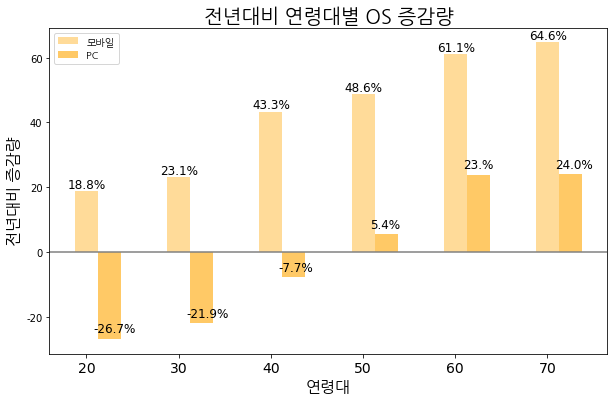

In [43]:
age = online_OS_grouping['연령대'].unique()
mobile = online_OS_grouping[online_OS_grouping['OS유형']=='Mobile']['증감률'].tolist()
pc = online_OS_grouping[online_OS_grouping['OS유형']=='PC']['증감률'].tolist()

x = np.arange(0,len(age))
width = 0.25

plt.rcParams['figure.figsize'] = [10, 6]
fig, ax = plt.subplots()
rects1 = ax.bar(x, height = mobile, width=width, label='모바일', color='orange', alpha=0.4)
rects2 = ax.bar(x + width, height = pc, width=width, label='PC', color='orange', alpha=0.6)

ax.set_ylabel('전년대비 증감량',fontsize=16,fontproperties=fprop)
ax.set_xlabel('연령대',fontsize=16,fontproperties=fprop)
ax.set_title('전년대비 연령대별 OS 증감량',fontsize=20,fontproperties=fprop)

ax.set_xticks(x)
ax.set_xticklabels(age, fontsize=14)
ax.axhline(y=0, color='gray')

for i,value in enumerate(mobile):
    ax.annotate(str(value)[:4]+'%',xy=(x[i]-0.2,value+1),fontsize=12)

for i,value in enumerate(pc):
    ax.annotate(str(value)[:-14]+'%',xy=(x[i]+0.08,value+2),fontsize=12)

ax.legend(loc='upper left',prop=fprop)
plt.show()

- 연령대가 높아질수록 __모바일 사용량이 증가__하였다
- 반대로, 연령대가 낮아질수록 __PC 사용량은 점차 감소__한다.

## 3) 특정 연령대의 테마별 OS 사용량 분석 및 시각화
- 코로나 예방품: 건강관련용품, 안전용품, 업소위생용품
- 식사: 가공식품, 농축수산물, 건강식품
- 생활: 헤어바디용품, 생활용품, 세탁청소세면
- 취미: 완구키덜트게임, 헬스기구용품, 주방수납잡화

In [44]:
def online_OS_category_grouping(categories=[]):
    df_2019 = pd.DataFrame()
    df_2020 = pd.DataFrame()

    for category in categories:
        new_df_2019 = online_OS_2019[online_OS_2019['소비업종'] == category]
        new_df_2020 = online_OS_2020[online_OS_2020['소비업종'] == category]
        df_2019 = pd.concat([df_2019,new_df_2019])
        df_2020 = pd.concat([df_2020,new_df_2020])

    df_2019_grouping = df_2019.groupby(['연령대','OS유형'])[['소비건수']].sum()
    df_2020_grouping = df_2020.groupby(['연령대','OS유형'])[['소비건수']].sum()

    df = pd.concat([df_2019_grouping,  df_2020_grouping,  df_2020_grouping - df_2019_grouping ],axis=1)
    df.columns = ['2019년','2020년','차이']
    df['증감률'] = df['차이'] / df['2019년'] * 100
    df = df.reset_index()
    return df

In [45]:
def online_OS_category_grouping_vis(data = df,title=''):
    mobile = data[ ((data['연령대']==20) | (data['연령대']==30)) & (data['OS유형'] == 'Mobile')]['증감률'].tolist()
    pc = data[ ((data['연령대']==20) | (data['연령대']==30)) & (data['OS유형'] == 'PC')]['증감률'].tolist()

    x = np.arange(0,1,0.5)
    width = 0.25

    plt.rcParams['figure.figsize'] = [10, 6]
    fig, ax = plt.subplots()
    rects1 = ax.bar(x-width/2, height = mobile, width=width, label='모바일', color='orange', alpha=0.4)
    rects2 = ax.bar(x+width/2, height = pc, width=width, label='PC', color='orange', alpha=0.6)

    ax.set_ylabel('전년대비 증감량',fontsize=16,fontproperties=fprop)
    ax.set_xlabel('연령대',fontsize=16,fontproperties=fprop)
    ax.set_title(title+' 테마 연령대별 OS 증감량',fontsize=20,fontproperties=fprop)

    ax.set_xticks(x)
    ax.set_xticklabels(['20대','30대'], fontsize=14)
    for label in ax.get_xticklabels() :
        label.set_fontproperties(fprop)
    ax.axhline(y=0, color='gray')

    for i,value in enumerate(mobile):
        ax.annotate(str(value)[:4]+'%',xy=(x[i]-width/2,value),fontsize=15)

    for i,value in enumerate(pc):
        ax.annotate(str(value)[:4]+'%',xy=(x[i]+width/2,value),fontsize=15)

    ax.legend(loc='upper right',prop=fprop)
    plt.show()

### ① 코로나 예방품 

In [46]:
categories = ['건강관련용품', '안전용품', '업소위생용품']
online_OS_corona = online_OS_category_grouping(categories)
online_OS_corona

,연령대,OS유형,2019년,2020년,차이,증감률
0,20,Mobile,201118,586746,385628,191.742161
1,20,PC,16902,24135,7233,42.793752
2,30,Mobile,400483,1494822,1094339,273.254795
3,30,PC,62848,113080,50232,79.926171
4,40,Mobile,284575,1247361,962786,338.324168
5,40,PC,100335,215968,115633,115.246923
6,50,Mobile,96520,341925,245405,254.253005
7,50,PC,71187,166270,95083,133.567927
8,60,Mobile,19649,63982,44333,225.624714
9,60,PC,27012,64306,37294,138.064564


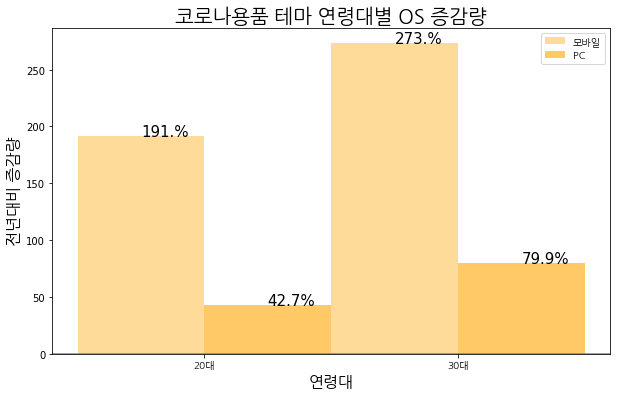

In [47]:
online_OS_category_grouping_vis(online_OS_corona,'코로나용품')

### ② 식사

In [48]:
categories = ['가공식품', '농축수산물', '건강식품']
online_OS_dining = online_OS_category_grouping(categories)
online_OS_dining

,연령대,OS유형,2019년,2020년,차이,증감률
0,20,Mobile,5522857,8054287,2531430,45.835516
1,20,PC,126293,96155,-30138,-23.863555
2,30,Mobile,8119814,12469404,4349590,53.567606
3,30,PC,428156,394186,-33970,-7.934024
4,40,Mobile,4922639,8972822,4050183,82.276661
5,40,PC,690883,769182,78299,11.333178
6,50,Mobile,1665820,2853386,1187566,71.290175
7,50,PC,494787,627649,132862,26.852363
8,60,Mobile,387952,690215,302263,77.912474
9,60,PC,186348,262687,76339,40.965827


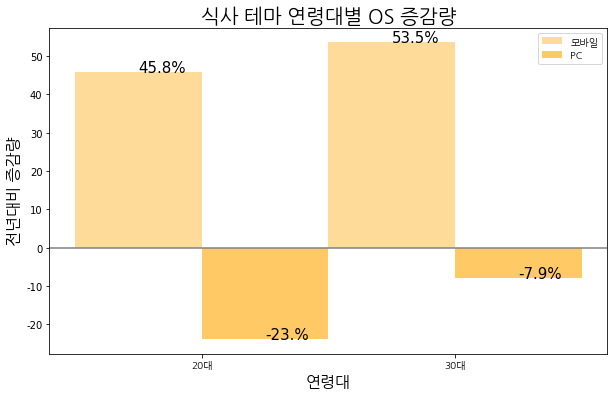

In [49]:
online_OS_category_grouping_vis(online_OS_dining,'식사')

### ③ 생활

In [50]:
categories = ['헤어바디용품', '생활용품', '세탁청소세면']
online_OS_life = online_OS_category_grouping(categories)
online_OS_life

,연령대,OS유형,2019년,2020년,차이,증감률
0,20,Mobile,863051,1022312,159261,18.453255
1,20,PC,56826,40862,-15964,-28.092774
2,30,Mobile,2092512,2489162,396650,18.955686
3,30,PC,229471,199358,-30113,-13.122791
4,40,Mobile,1506709,2024187,517478,34.344920
5,40,PC,336675,353844,17169,5.099577
6,50,Mobile,496567,688797,192230,38.711795
7,50,PC,215714,263904,48190,22.339765
8,60,Mobile,94610,144321,49711,52.543072
9,60,PC,72818,103103,30285,41.589991


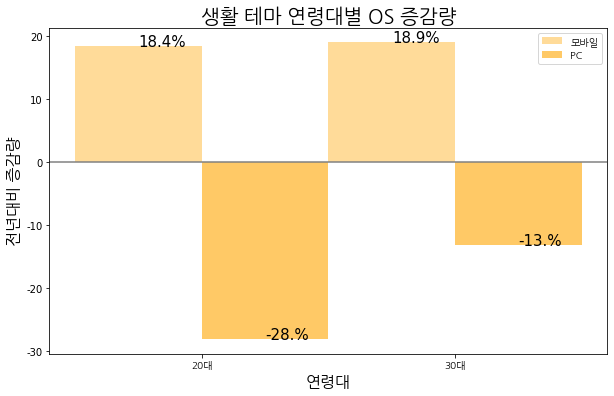

In [51]:
online_OS_category_grouping_vis(online_OS_life,'생활')

### ④ 취미

In [52]:
categories = ['완구키덜트게임', '헬스기구용품', '주방수납잡화']
online_OS_hobby = online_OS_category_grouping(categories)
online_OS_hobby

,연령대,OS유형,2019년,2020년,차이,증감률
0,20,Mobile,339258,443277,104019,30.660736
1,20,PC,37270,34695,-2575,-6.909042
2,30,Mobile,913981,1154212,240231,26.284026
3,30,PC,135461,112298,-23163,-17.099387
4,40,Mobile,467429,691132,223703,47.858177
5,40,PC,177922,171742,-6180,-3.473432
6,50,Mobile,107456,165319,57863,53.848087
7,50,PC,85548,98828,13280,15.523449
8,60,Mobile,24920,40778,15858,63.635634
9,60,PC,30667,38540,7873,25.672547


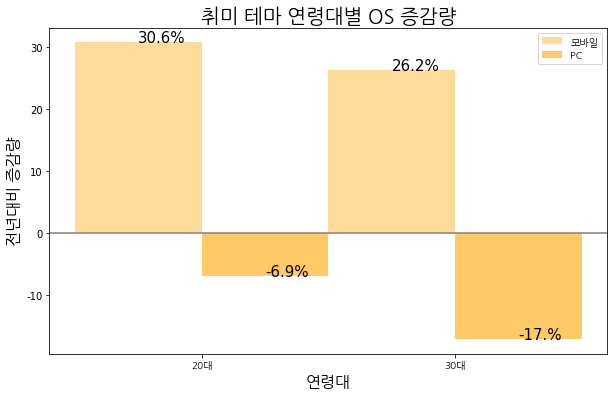

In [53]:
online_OS_category_grouping_vis(online_OS_hobby,'취미')

# 4. [분석3] 연령대별 유망 업종 선종 및 분석

In [54]:
offline['소비일자'] = offline['소비일자'].astype('str')
online['소비일자'] = online['소비일자'].astype('str')
online['연령대'] = online['연령대'].astype('str')

offline_2019 = offline[offline['소비일자'].str.contains('2019')]
offline_2020 = offline[offline['소비일자'].str.contains('2020')]
online_2019 = online[online['소비일자'].str.contains('2019')]
online_2020 = online[online['소비일자'].str.contains('2020')]

In [55]:
def barchart_age(onoff=0, category = '패션/잡화', age = '20'):
    if onoff == 0:
        a = online_2019[(online_2019['연령대'].str.contains(age)) & (online_2019['소비업종'] == category)]['소비건수'].sum()
        b = online_2020[(online_2020['연령대'].str.contains(age)) & (online_2020['소비업종'] == category)]['소비건수'].sum()
    else:
        a = offline_2019[(offline_2019['연령대'].str.contains(age)) & (offline_2019['소비업종'] == category)]['소비건수'].sum()
        b = offline_2020[(offline_2020['연령대'].str.contains(age)) & (offline_2020['소비업종'] == category)]['소비건수'].sum()

    c = b-a
    d = c/a * 100

    if onoff == 0:
        e = str(abs(c)) + '건 증가' + '\n' + str(round(abs(d))) + '% 증가'
        plt.rcParams['figure.figsize'] = [6, 4]
        x = np.arange(0,1,0.5)
        labels = ['2019년','2020년']
        width = 0.5

        fig, ax = plt.subplots()
        rects1 = ax.bar(0, height=a, width=width, label='2019년', color='yellowgreen', alpha=0.5)
        rects2 = ax.bar(0.5, height=b, width=width, label='2020년', color='yellowgreen', alpha=0.9)

        ax.set_ylabel('구매건수',fontsize=16,fontproperties=fprop)
        ax.set_xlabel('년도',fontsize=16,fontproperties=fprop)
        ax.set_title( category +' 구매건수',fontsize=20,fontproperties=fprop)
        ax.annotate(str(a)+'건',xy=(-0.1,a-a*0.05),fontsize=12,fontproperties=fprop)
        ax.annotate(str(b)+'건',xy=(0.4,b-b*0.07),fontsize=12,fontproperties=fprop)
        ax.annotate(e, xy=(0.25,b/2),size=13, ha='center', va="center", bbox=dict(boxstyle="round", alpha=0.8, ec="gray"),fontproperties=fprop)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize=14)
        for label in ax.get_xticklabels() :
            label.set_fontproperties(fprop)
        ax.legend(loc='lower left',prop=fprop)
        plt.show()
    else:
        e = str(abs(c))[:-2] + '건 감소' + '\n' + str(round(abs(d))) + '% 감소'
        plt.rcParams['figure.figsize'] = [6, 4]
        x = np.arange(0,1,0.5)
        labels = ['2019년','2020년']
        width = 0.5

        fig, ax = plt.subplots()
        rects1 = ax.bar(0, height=a, width=width, label='2019년', color='skyblue', alpha=0.4)
        rects2 = ax.bar(0.5, height=b, width=width, label='2020년', color='skyblue', alpha=0.8)

        ax.set_ylabel('구매건수',fontsize=16,fontproperties=fprop)
        ax.set_xlabel('년도',fontsize=16,fontproperties=fprop)
        ax.set_title( category +' 구매건수',fontsize=20,fontproperties=fprop)
        ax.annotate(str(a)[:-2]+'건',xy=(-0.1,a-a*0.05),fontsize=12,fontproperties=fprop)
        ax.annotate(str(b)[:-2]+'건',xy=(0.4,b-b*0.07),fontsize=12,fontproperties=fprop)
        ax.annotate(e, xy=(0.25,b/2),size=13, ha='center', va="center", bbox=dict(boxstyle="round", alpha=0.8, ec="gray"),fontproperties=fprop)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize=14)
        for label in ax.get_xticklabels() :
            label.set_fontproperties(fprop)
        ax.legend(loc='lower left',prop=fprop)
        plt.show()

## 1) 20대 소비 트렌드
### ① 오프라인

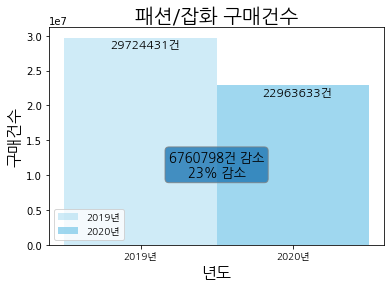

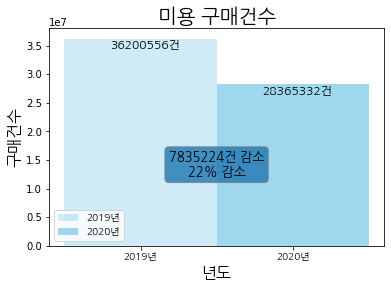

In [56]:
barchart_age(1,'패션/잡화','20')
barchart_age(1,'미용','20')

### ② 온라인

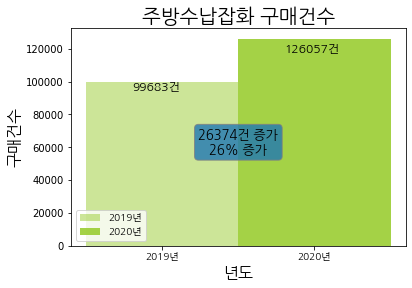

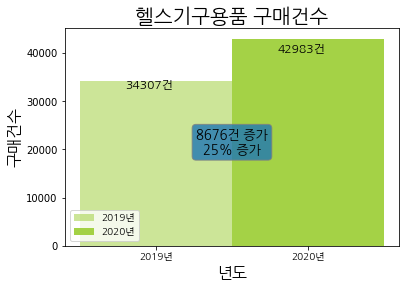

In [57]:
barchart_age(0,'주방수납잡화','20')
barchart_age(0,'헬스기구용품','20')

## 2) 30대 소비 트렌드
### ① 오프라인

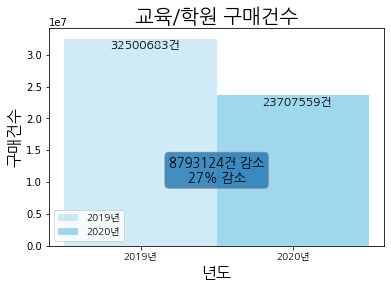

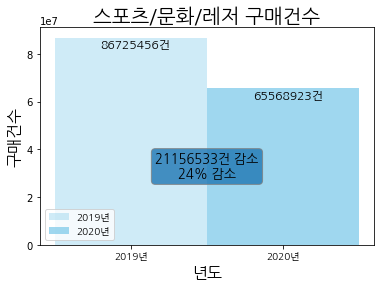

In [58]:
barchart_age(1,'교육/학원','30')
barchart_age(1,'스포츠/문화/레저','30')

### ② 온라인

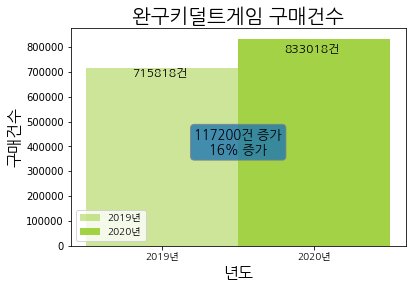

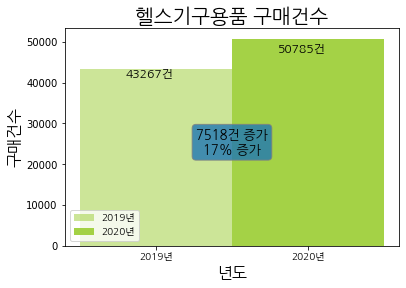

In [59]:
barchart_age(0,'완구키덜트게임','30')
barchart_age(0,'헬스기구용품','30')

## 3) 40대 소비 트렌드
### ① 오프라인

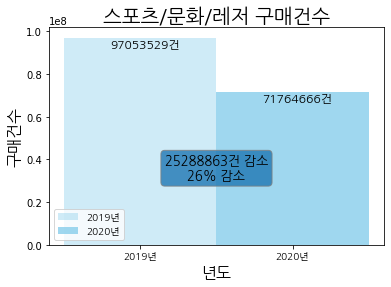

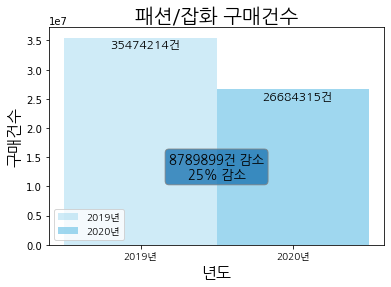

In [60]:
barchart_age(1,'스포츠/문화/레저','40')
barchart_age(1,'패션/잡화','40')

### ② 온라인

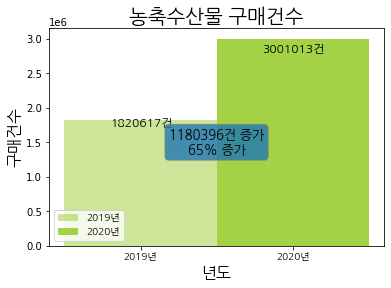

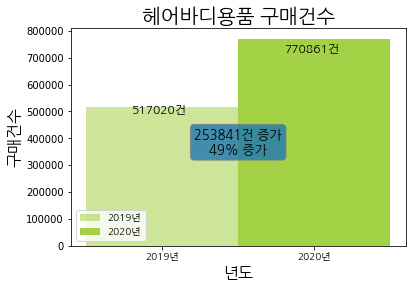

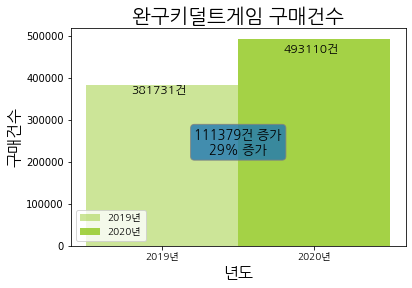

In [61]:
barchart_age(0,'농축수산물','40')
barchart_age(0,'헤어바디용품','40')
barchart_age(0,'완구키덜트게임','40')

## 4) 50대 소비 트렌드
### ① 오프라인

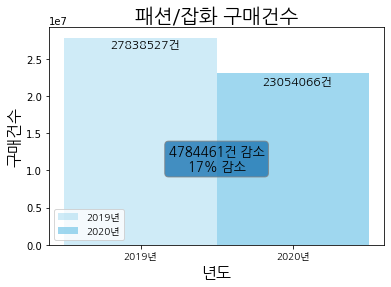

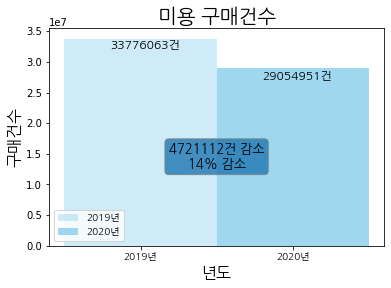

In [62]:
barchart_age(1,'패션/잡화','50')
barchart_age(1,'미용','50')

### ② 온라인

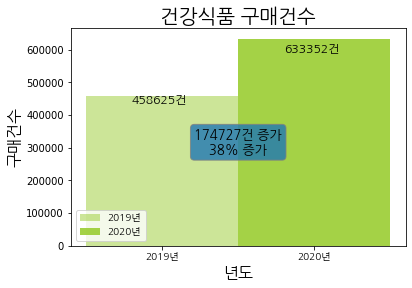

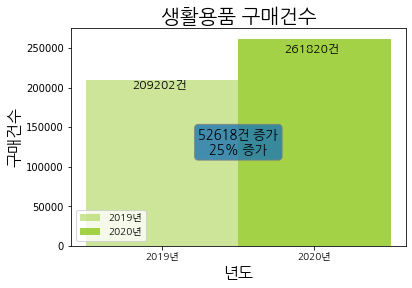

In [63]:
barchart_age(0,'건강식품','50')
barchart_age(0,'생활용품','50')

## 5) 60대 소비 트렌드
### ① 오프라인

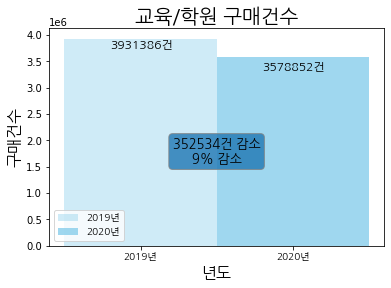

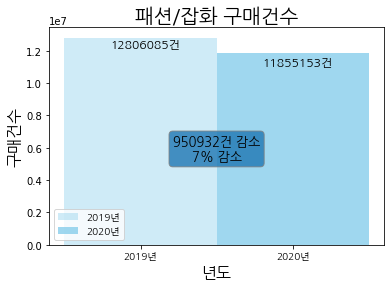

In [64]:
barchart_age(1,'교육/학원','60')
barchart_age(1,'패션/잡화','60')

### ② 온라인

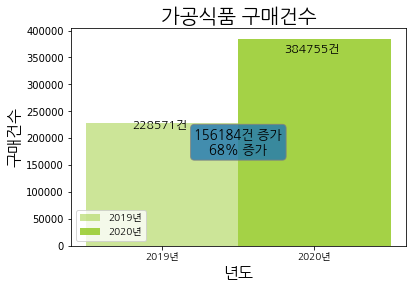

In [65]:
barchart_age(0,'가공식품','60')